# Bob or Kendrick

Two of the great wordsmiths of the modern era. Any fan would be able discern the artist from the lyrics, but can a machine?

This notebook will look to adopt a few different methods to answer this question.

Methods:
- Sentiment-based
- Language-based

The basic version of the model will

In [452]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.manifold import TSNE

from sklearn.utils import class_weight
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import textacy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import tqdm

## Data Import

In [142]:
bob = pd.read_csv('bob.csv', index_col=0)
ken = pd.read_csv('kendrick.csv', index_col=0)

In [143]:
df = pd.concat([bob, ken], ignore_index=True)
del bob, ken

## Data Prep

In [129]:
def drop_breaks(lyrics):
    '''
    Strip our section marker from lyrics i.e. ['Verse 1'] and line breaks
    '''
    return re.sub(r'\[(.*?)\]', '', lyrics)

In [150]:
def remove_digits(lyrics):
    '''
    Strip our section marker from lyrics i.e. ['Verse 1'] and line breaks
    '''
    return re.sub(r'[0-9]', '', lyrics)

In [96]:
def process_text(songs, pos=False):
    '''
    Cleans sentences from stop words and punctuation and filters by pos tags if given
    returns cleaned sentence and tokenized sentence
    '''   
    nlp = textacy.load_spacy_lang('en_core_web_sm')
    
    texts, tokenised_texts = [], []
        
    if pos: 
        for lyrics in tqdm.notebook.tqdm(nlp.pipe(songs, batch_size=200)):
            assert lyrics.is_parsed
            tokens = [token
                      for token in lyrics 
                      if token.is_stop == False
                      and token.pos_ in pos
                      and token.pos_ != 'PUNCT']
            doc_ = ''
            for token in tokens:
                doc_ += str(token) + ' '
            
            doc_ = doc_.strip()
            texts.append(doc_)
            tokenised_texts.append(tokens)
    
    
    else:    
        for lyrics in tqdm.notebook.tqdm(nlp.pipe(songs, batch_size=200)):
            assert lyrics.is_parsed
            tokens = [token
                      for token in lyrics 
                      if token.is_stop == False
                      and token.pos_ != 'PUNCT']
            doc_ = ''
            for token in tokens:
                doc_ += str(token) + ' '
            
            doc_ = doc_.strip()
            texts.append(doc_)
            tokenised_texts.append(tokens)
            
    return texts, tokenised_texts

In [298]:
df['song'] = df.song.str.replace('\n',' ')\

In [151]:
pos = ['NOUN', 'ADJ', 'VERB', 'ADV']

df['lyrics'] = df.lyrics.str.replace('\n',' ')\
                            .apply(lambda x: drop_breaks(x))\
                            .apply(lambda x: remove_digits(x))\
                            .str.lower()

processed_quotes, tokenised_quotes = process_text(df.lyrics)

df['lyrics_processed'] = processed_quotes
df['lyrics_tokenised'] = tokenised_quotes

In [155]:
df.head(2)

,artist,song,lyrics,lyrics_processed,lyrics_tokenised
0,Bob Dylan,Murder Most Foul,"it was a dark day in dallas, november ' a da...",dark day dallas november day live infamy pre...,"[ , dark, day, dallas, november, day, live, ..."
1,Bob Dylan,Blowin’ in the Wind,how many roads must a man walk down before y...,roads man walk man seas white dove sail sleeps...,"[ , roads, man, walk, man, seas, white, dove,..."


In [41]:
df['artist'].value_counts(normalize = True)

Bob Dylan         0.666667
Kendrick Lamar    0.333333
Name: artist, dtype: float64

## Data Exploration and Viz

In [358]:
def vectorise(ngram_range, max_feats, input_data):
    '''
    Returns non-sparse format. With a larger dataset rather return
    '''
    vect = TfidfVectorizer(ngram_range, max_features=max_feats)
    
    return vect.fit(input_data), pd.DataFrame(vect.fit_transform(input_data).todense(), columns=vect.get_feature_names(), index=input_data.index)

In [406]:
vectoriser, language_vector_data= vectorise(ngram_range=(1, 1), max_feats=1000, input_data=df['lyrics_processed'])

In [407]:
# Store X for later
X = language_vector_data.copy()

In [408]:
language_vector_data['artist']=df['artist']

In [362]:
language_vector_data.groupby('artist').mean().T.sort_values('Bob Dylan', ascending=False)['Bob Dylan'].head(10)

like    0.061811
ll      0.054287
said    0.048949
know    0.048405
got     0.048195
love    0.047761
re      0.047352
time    0.044198
come    0.040009
oh      0.039634
Name: Bob Dylan, dtype: float64

In [320]:
language_vector_data.groupby('artist').mean().T.sort_values('Kendrick Lamar', ascending=False)['Kendrick Lamar'].head(10)

nigga     0.096009
like      0.074026
got       0.068209
know      0.065979
fuck      0.065657
ai        0.056846
shit      0.056431
niggas    0.050788
love      0.048572
bitch     0.045981
Name: Kendrick Lamar, dtype: float64

In [455]:
X_embedded = pd.DataFrame(TSNE(n_components=2).fit_transform(X), columns=['c1','c2'], index=X.index)

In [456]:
X_embedded['artist'] = df['artist']

In [457]:
sns.scatterplot(X_embedded['c1'],X_embedded['c2'],hue='artist')

ValueError: Could not interpret input 'artist'

## Modelling Functions

In [245]:
def plot_confusion(cm):
    '''
    Generate a confusion matrix
    '''
    plt.figure(figsize=(6,6))
    ax = sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True,  cmap = 'coolwarm')
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    plt.xticks([i-0.5 for i in range(1,3)], ['Bob Dylan', 'Kendrick Lamar'])
    plt.yticks([i-0.5 for i in range(1,3)], ['Bob Dylan', 'Kendrick Lamar'])
    b, t = plt.ylim() 
    b += 0.5 
    t -= 0.5 
    plt.ylim(b, t) 
    plt.show()

In [409]:
def generate_class_weights(y):
    '''
    Get class weights to help manage slight class imbalance
    '''
    return dict(zip(list(np.unique(y)), 
                    class_weight.compute_class_weight('balanced', np.unique(y), y)))


## First Model

In [410]:
class_weights = generate_class_weights(df['artist'])

In [411]:
X_train, X_test, y_train, y_test = train_test_split(X, df['artist'],
                                                    test_size=0.2,
                                                    random_state=1,
                                                    shuffle=True,
                                                    stratify=df['artist'])

In [412]:
param_grid = {
    
    'n_estimators':[50,100,150,200,250,300],
    'max_depth':[5,7,10,15]
    
}

grid = GridSearchCV(RandomForestClassifier(random_state=1,
                                           class_weight=class_weights),
                                           param_grid,
                                           cv=5,
                                           n_jobs=2).fit(X_train, y_train)

print(grid.best_score_, grid.best_params_)

0.95 {'max_depth': 10, 'n_estimators': 50}


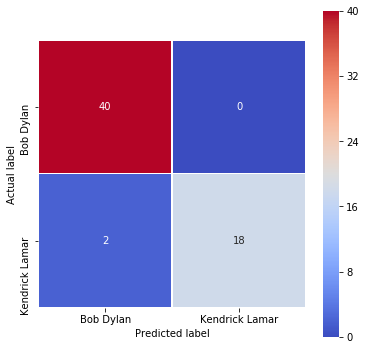

In [413]:
rf = RandomForestClassifier(random_state = 1,
                             max_depth=grid.best_params_['max_depth'],
                             n_estimators=grid.best_params_['n_estimators'],
                             class_weight=class_weights).fit(X_train, y_train)

preds = rf.predict(X_test)
cm_rf = confusion_matrix(y_test, preds)
plot_confusion(cm_rf)

In [388]:
imps = pd.DataFrame({'importance':clf.feature_importances_,
                     'feature':X_train.columns})

imps.sort_values('importance').tail(15)

,importance,feature
248,0.012942,em
496,0.013396,life
24,0.013477,ass
6,0.013720,ai
165,0.014073,compton
91,0.014697,bout
326,0.015054,fuck
62,0.015373,bitch
357,0.017219,got
988,0.018763,yeah


Clearly its easier to identify Kendrick's terms than Bob's!

Lets check where we actually misclassify for our 2 errors.

In [389]:
results = pd.DataFrame({'actual':y_test,
                        'predicted':preds
                        }, index=y_test.index)

results['lyrics'], results['song'] = df['lyrics'], df['song']

In [390]:
mistakes = results[results['actual']!=results['predicted']]

In [391]:
for key, value in dict(zip(list(mistakes['song'].values), list(mistakes['lyrics'].values))).items():
    print('Song: ' + key)
    print('   ')
    print(value)
    print('  ')

Song: Black Panther
   
  (why i go easy?) (know why i go easy) wait    king of my city, king of my country, king of my homeland king of the filthy, king of the fallen, we livin' again king of the shooters, looters, boosters, and ghettos poppin' king of the past, present, future, my ancestors watchin' king of the culture, king of the soldiers, king of the bloodshed king of the wisdom, king of the ocean, king of the respect king of the optimistics and dreamers that go and get it king of the winner's district and geniuses with conviction king of the fighters, king of the fathers, king of the belated king of the answer, king of the problem, king of the forsaken king of the empathy, you resent me, king of remorse king of my enemies, may they fall defeat, i rejoice king of the skyscrapers, dodgin' haters, broke religion    nine faces, go against 'em, i erased 'em with precision i embrace them with collision, kings did it king's vision, black panther, king kendrick, all hail the king! i drop

Not so surprising really! These are both Kendrick tracks but they're missing some of his usual language.

Eyeballing some of the language in both of these tracks, its really not immediately clear who's written them. Thematically, its likely that Black Panther would be a Kendrick track and some of the phrasing in untitled 04 is also quite clearly Kendrick but to a basic model, these features shouldn't really be discernible.

In [337]:
print(classification_report(y_test, preds))

                precision    recall  f1-score   support

     Bob Dylan       0.95      1.00      0.98        40
Kendrick Lamar       1.00      0.90      0.95        20

     micro avg       0.97      0.97      0.97        60
     macro avg       0.98      0.95      0.96        60
  weighted avg       0.97      0.97      0.97        60



As we gauged from the confusion matrix, our accuracy, precision and recall were all strong.

## Futher Models

0.9375 {'C': 0.9111627561154896, 'penalty': 'l2'}


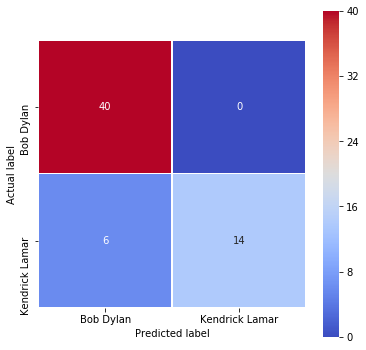

In [433]:
'''
Logistic Regression
'''

param_grid = {
    
    'C':np.logspace(-4,4,100),
    'penalty':['l1','l2']
    
}

grid = GridSearchCV(LogisticRegression(random_state=1, solver = 'saga',
                                           class_weight=class_weights),
                                           param_grid,
                                           cv=5,
                                           n_jobs=2).fit(X_train, y_train)

print(grid.best_score_, grid.best_params_)

logreg = LogisticRegression(random_state = 1, solver = 'saga',
                             C=grid.best_params_['C'],
                             penalty=grid.best_params_['penalty'],
                             class_weight=class_weights).fit(X_train, y_train)

preds = clf.predict(X_test)
cm_rf = confusion_matrix(y_test, preds)
plot_confusion(cm_rf)

In [ ]:
vectoriser, language_vector_data= vectorise(ngram_range=(1, 1), max_feats=1000, input_data=df['lyrics_processed'])

## Optimised Model

In [ ]:
def export_models(classification_model, class_model_name, vectoriser, vectoriser_name):
    '''
    Retrieve models for classification and for 
    word vectorising
    '''
    return joblib.dump(classification_model, class_model_name), joblib.dump(vectoriser, vectoriser_name)

## Model Optimised for Classifying Lyric

In [ ]:
def import_models(classification_model, vectoriser):
    '''
    Retrieve models for classification and for 
    word vectorising
    '''
    return joblib.load(classification_model), joblib.load(vectoriser)

In [425]:
def gather_lyric():
    '''
    Simply asking for an input
    '''
    return input('Try your lyric here: ').lower()


In [426]:
def convert_lyric_to_vector(lyric, vectoriser):
    '''
    Creates predictor observation with vectorised
    weightings
    '''
    return pd.DataFrame(vectoriser.transform([lyric]).todense(), columns=vectoriser.get_feature_names())


In [450]:
def generate_prediction(vectoriser, model, num_preds):
    '''
    Print n predictions for an inputted lyric using
    a given vectoriser and pre-trained model
    '''
    for i in range(num_preds):
        lyric=gather_lyric()
        print('{} probably sang that.'.format(model.predict(convert_lyric_to_vector(lyric, vectoriser))[0]))
        print('_____________________________________________')

In [451]:
generate_prediction(vectoriser, logreg, 2)

Try your lyric here: shot a nigga in compton
Kendrick Lamar probably sang that.
_____________________________________________
Try your lyric here: blowing in the wind
Bob Dylan probably sang that.
_____________________________________________
